In [1]:
import pandas as pd
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import numpy as np
import re
import joblib

In [2]:
data = pd.read_csv(r'..\preprocessing\tidy_data.csv', encoding = 'utf-8-sig')

In [3]:
data = data.dropna()

In [4]:
# Số dòng và cột của dữ liệu
data.shape

(10928, 26)

In [5]:
# Các thuộc tính của dữ liệu
data.columns

Index(['name', 'brand', 'condition', 'price_old', 'price_new', 'warranty',
       'CPU', 'RAM', 'capacity', 'time', 'battery', 'screen_size',
       'operating_system', 'display_technology', 'screen_resolution', 'weight',
       'bluetooth', 'refresh_rate', 'GPU', 'color', 'image', 'has_nano_sim',
       'has_esim', 'height', 'width', 'depth'],
      dtype='object')

In [6]:
data.describe()

,price_old,price_new,RAM,capacity,battery,screen_size,screen_resolution,weight,refresh_rate,has_nano_sim,has_esim,height,width,depth
count,1.092800e+04,1.092800e+04,10928.000000,10928.000000,10928.000000,10928.000000,1.092800e+04,10928.000000,10928.000000,10928.0,10928.000000,10928.000000,10928.000000,10928.000000
mean,8.657490e+06,1.382425e+07,7.707952,222.773426,4579.718064,6.293948,2.457773e+06,187.993503,98.013909,1.0,0.405747,157.821568,75.272965,11.252679
std,6.970002e+06,1.106870e+07,3.468098,151.920992,1109.118893,1.209903,1.135541e+06,26.336526,29.036443,0.0,0.491058,12.572043,11.461572,13.190693
min,1.500000e+05,4.100000e+05,0.046875,0.125000,1000.000000,1.770000,1.920000e+04,75.000000,30.000000,1.0,0.000000,71.500000,7.000000,5.000000
25%,3.010000e+06,4.490000e+06,6.000000,128.000000,4383.000000,6.560000,1.180800e+06,182.000000,90.000000,1.0,0.000000,155.700000,74.420000,7.680000
50%,7.020000e+06,9.990000e+06,8.000000,256.000000,5000.000000,6.670000,2.592000e+06,192.000000,120.000000,1.0,0.000000,162.200000,75.940000,7.900000
75%,1.270000e+07,2.299000e+07,12.000000,256.000000,5030.000000,6.700000,3.204000e+06,198.000000,120.000000,1.0,1.000000,165.100000,77.300000,8.300000
max,3.707000e+07,4.799000e+07,16.000000,1024.000000,6600.000000,7.600000,4.608000e+06,240.000000,144.000000,1.0,1.000000,191.900000,132.600000,88.900000


# Tính khoảng thời gian điện thoại đã ra mắt

In [7]:
data['time'] = pd.to_datetime(data['time'])

In [8]:
# Tính toán khoảng thời gian hiện tại - 'time'
data['time_difference'] = datetime.now() - data['time']
data['time_difference'] = data['time_difference'].dt.days

In [9]:
data.drop(columns=['time'], inplace=True)

# Tính thời gian hết bảo hành

In [10]:
processed_results = []
current_date = datetime.now() # Lấy ngày và giờ hiện tại

for index, item in data['warranty'].items():
    item = str(item).strip() # Đảm bảo item là chuỗi và loại bỏ khoảng trắng

    # Kiểm tra nếu có chứa "tháng"
    if "tháng" in item:
        num_months_str = item.replace("tháng", "").strip()
        num_months = int(num_months_str)

        # Xử lý cộng tháng
        year = current_date.year
        month = current_date.month + num_months
        day = current_date.day

        while month > 12:
            month -= 12
            year += 1
                
        # Xử lý trường hợp ngày không hợp lệ sau khi cộng tháng
        try:
            new_date = datetime(year, month, day)
        except ValueError:
            # Nếu ngày không hợp lệ, lấy ngày cuối cùng của tháng đó
            last_day_of_month = calendar.monthrange(year, month)[1]
            new_date = datetime(year, month, last_day_of_month)

        # Cập nhật giá trị
        data.loc[index, 'warranty'] = new_date.strftime("%d/%m/%Y")
    else:
            datetime.strptime(item, "%d/%m/%Y")
            data.loc[index, 'warranty'] = item 

# Chuyển dữ liệu sang kiểu datetime
data['warranty'] = pd.to_datetime(data['warranty'], format='%d/%m/%Y', errors='coerce')

In [11]:
# Tạo một Series mới cho current_date
current_date_series = pd.Series([current_date] * len(data))

# Tính hiệu số ngày
time_remaining = data['warranty'] - current_date_series

# Lưu vào một cột mới
data['day_remaining_warranty'] = time_remaining.dt.days + 1
data['day_remaining_warranty'] = data['day_remaining_warranty'].fillna(0)

In [12]:
data.drop(columns=['warranty'], inplace=True)

# Chọn thuộc tính

## Kiểm tra các thuộc tính object

In [13]:
from scipy.stats import entropy

categorical_columns = data.select_dtypes(include=['object']).columns

def calculate_entropy(data):
    entropy_values = {}
    for column in data.columns:
        probabilities = data[column].dropna().value_counts(normalize=True)
        entropy_values[column] = entropy(probabilities, base=2)
    return entropy_values

# Tính entropy cho từng thuộc tính
entropy_results = calculate_entropy(data[categorical_columns])
print(entropy_results)

{'name': 6.440265615861786, 'brand': 2.828631465994293, 'condition': 0.46525072594469163, 'CPU': 5.127603546950079, 'operating_system': 2.4239292124843366, 'display_technology': 2.752689350603019, 'bluetooth': 2.3778052024057277, 'GPU': 4.269559741468382, 'color': 3.8914706322373793, 'image': 13.415741768290085}


- image có entropy cao nhất (13.42), cho thấy mỗi giá trị gần như là duy nhất, không hữu ích cho mô hình. 
- Các biến như name, CPU, GPU có entropy cao (trên 4), phản ánh sự đa dạng lớn. 
- brand, display_technology, color có entropy trung bình (khoảng 2.7–3.9), cân bằng giữa thông tin và độ phức tạp. 
- condition, bluetooth, operating_system có entropy thấp (dưới 2.5), cho thấy ít giá trị phân loại, ít khả năng phân biệt hơn.


In [14]:
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(r-1, k-1))

categorical_columns = data.select_dtypes(include=['object']).columns

# Tính Cramér's V giữa từng thuộc tính object và price_old
cramer_results = {col: cramers_v(data[col], data['price_old']) for col in categorical_columns}
print(cramer_results)

{'name': 0.799679863770002, 'brand': 0.8619704799079416, 'condition': 0.7588928481081475, 'CPU': 0.7815367996070925, 'operating_system': 0.8826246966616209, 'display_technology': 0.7890983323422885, 'bluetooth': 0.7621177370923308, 'GPU': 0.8023542904267441, 'color': 0.6516187106934369, 'image': 1.0000000000000007}


- Các biến như brand, CPU, GPU, OS có Cramér’s V cao (trên 0.75), nghĩa là liên hệ rất mạnh với biến mục tiêu.
- Biến color có giá trị thấp nhất (≈ 0.65), cho thấy liên hệ yếu nhất trong nhóm.
- Biến image có Cramér’s V = 1.0 vì mỗi sản phẩm sẽ có link hình ảnh khác nhau -> không hữu ích trong phân tích.

In [15]:
categorical_columns = data.select_dtypes(include=['object']).columns

# Hàm kiểm định Kruskal-Wallis cho tất cả các biến phân loại với price_old
def kruskal_test(df, target):
    results = {}
    for col in categorical_columns:
        groups = [df[df[col] == cat][target] for cat in df[col].unique()]
        if len(groups) > 1:  
            kruskal_result = stats.kruskal(*groups)
            results[col] = {'Statistic': kruskal_result.statistic, 'p-value': kruskal_result.pvalue}
    return results

# Thực hiện kiểm định
kruskal_results = kruskal_test(data, 'price_old')
print(kruskal_results)

{'name': {'Statistic': 10815.388560331461, 'p-value': 0.0}, 'brand': {'Statistic': 5929.736335572413, 'p-value': 0.0}, 'condition': {'Statistic': 448.8753975244786, 'p-value': 5.713643819735046e-97}, 'CPU': {'Statistic': 10475.84564981027, 'p-value': 0.0}, 'operating_system': {'Statistic': 4487.563353340133, 'p-value': 0.0}, 'display_technology': {'Statistic': 9195.653350462535, 'p-value': 0.0}, 'bluetooth': {'Statistic': 4315.942562763112, 'p-value': 0.0}, 'GPU': {'Statistic': 9523.697456967806, 'p-value': 0.0}, 'color': {'Statistic': 3622.9055631683004, 'p-value': 0.0}, 'image': {'Statistic': 10927.000000000002, 'p-value': 0.49820090631630615}}


Biến image có p-value khá cao (0.498). Điều này có nghĩa là image không có mối liên hệ thống kê đáng kể với price_old.   
Biến color được loại bỏ vì tuy có ý nghĩa thống kê (p-value ≈ 0.0), nhưng mức độ liên hệ thực tế với biến mục tiêu lại yếu trong các biến (Cramér’s V ≈ 0.65)

In [16]:
data = data.drop(columns = ['image', 'color'])

## Kiểm tra các thuộc tính số

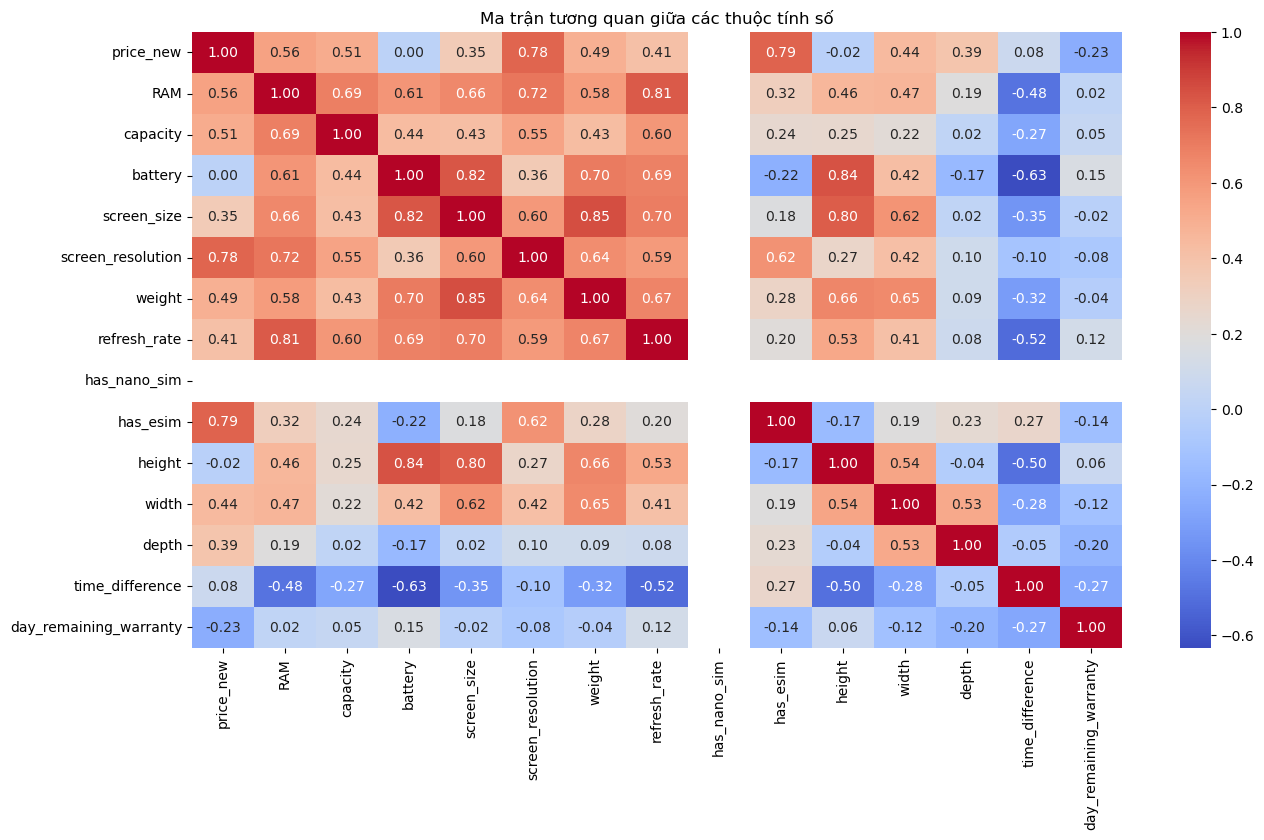

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = data.select_dtypes(include=np.number).drop('price_old', axis=1)

correlation_matrix = numeric_data.corr(method='pearson')
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các thuộc tính số")
plt.show()

In [18]:
# Ngưỡng tương quan
correlation_threshold = 0.8

# Lọc các cặp có độ tương quan cao
corr_series = correlation_matrix.unstack()
high_corr_pairs = corr_series[
    (corr_series.abs() > correlation_threshold) &
    (corr_series.abs() < 1.0)
]

high_corr_pairs = high_corr_pairs.sort_values(ascending=False, key=abs)
print(f"Các cặp thuộc tính có độ tương quan tuyệt đối > {correlation_threshold}:")
printed_pairs = set()
for (col1, col2), corr_value in high_corr_pairs.items():
    pair = tuple(sorted((col1, col2)))
    if pair not in printed_pairs:
        print(f"  - Cặp: {col1} - {col2}, Tương quan: {corr_value:.3f}")
        printed_pairs.add(pair)

Các cặp thuộc tính có độ tương quan tuyệt đối > 0.8:
  - Cặp: screen_size - weight, Tương quan: 0.849
  - Cặp: battery - height, Tương quan: 0.837
  - Cặp: battery - screen_size, Tương quan: 0.824
  - Cặp: RAM - refresh_rate, Tương quan: 0.811
  - Cặp: screen_size - height, Tương quan: 0.803


In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Tính VIF cho từng thuộc tính
X = add_constant(numeric_data)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data['feature'] != 'const']

print("Kết quả VIF cho các thuộc tính số:")
print(vif_data.sort_values(by='VIF', ascending=False))

Kết quả VIF cho các thuộc tính số:
                   feature         VIF
8             has_nano_sim  425.659158
3                  battery   15.632255
4              screen_size   10.722428
0                price_new    8.772793
1                      RAM    6.910555
6                   weight    6.539969
5        screen_resolution    5.280725
10                  height    5.131780
9                 has_esim    4.239066
7             refresh_rate    4.213184
11                   width    3.692662
13         time_difference    2.748189
2                 capacity    2.616650
12                   depth    2.361762
14  day_remaining_warranty    1.252589


Drop những thuộc tính VIF lớn 10 (đa cộng tuyến nghiêm trọng) và có tương quan tuyệt đối > 0.8.

In [20]:
data = data.drop(columns = ['has_nano_sim', 'battery', 'screen_size'])

Sau khi được loại bỏ các thuộc tính còn lại có độ tương quan giảm đáng kể.

In [21]:
# Chuyển đổi đơn vị của price old và price new từ đồng sang ngàn đồng
data['price_old'] = data['price_old']/1000
data['price_new'] = data['price_new']/1000

In [22]:
# Chuyển đổi đơn vị từ pixel sang MP (megapixel)
data['screen_resolution'] = data['screen_resolution']/1000000

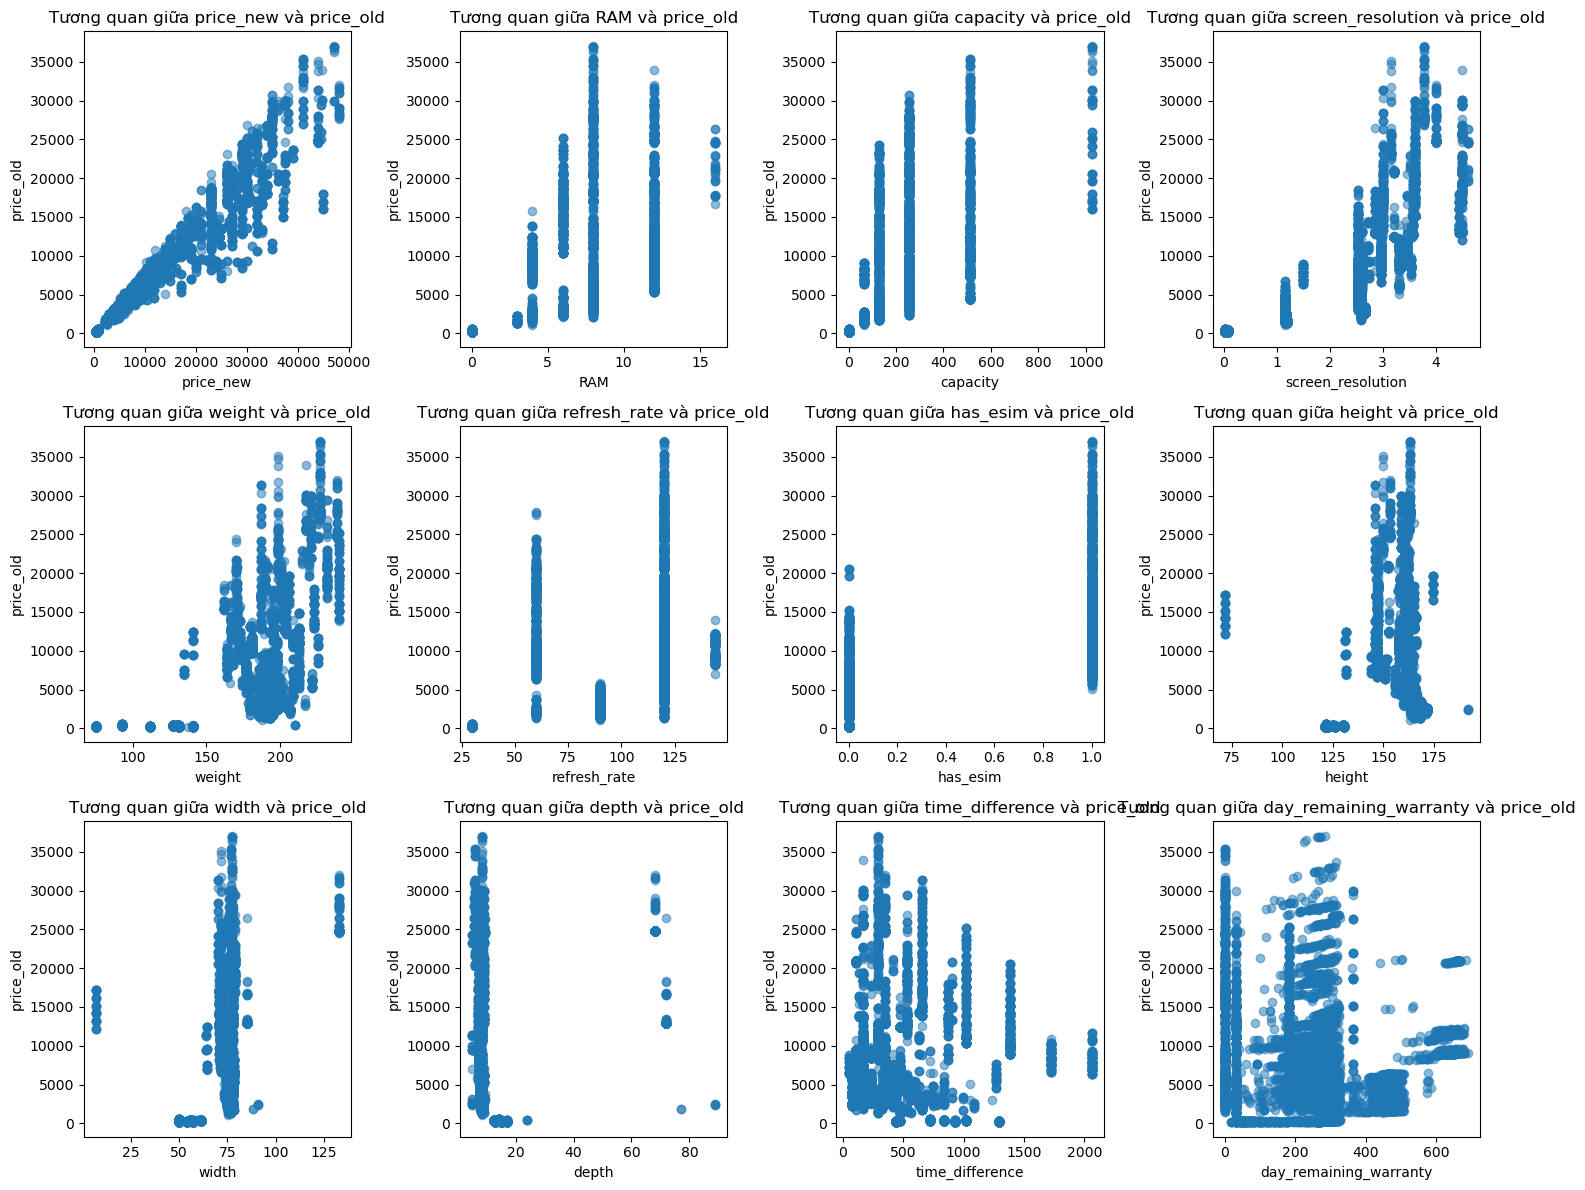

In [23]:
import matplotlib.pyplot as plt

# Lấy danh sách các cột số, ngoại trừ price_old
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("price_old")  # Loại bỏ target khỏi danh sách

# Xác định số hàng phù hợp
num_plots = len(numerical_cols)
ncols = 4  # Số cột cố định
nrows = (num_plots // ncols) + (1 if num_plots % ncols != 0 else 0)  # Điều chỉnh số hàng

# Vẽ biểu đồ scatter
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()[:num_plots]  # Chỉ lấy đủ số subplot cần thiết

for i, col in enumerate(numerical_cols):
    axes[i].scatter(data[col], data["price_old"], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("price_old")
    axes[i].set_title(f"Tương quan giữa {col} và price_old")

# Ẩn các subplot thừa (nếu có)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Scatterplot của day_remaining_warranty cho thấy nhiều điểm dữ liệu nhiễu, xu hướng ảnh hưởng đến price_old là không rõ ràng.

In [24]:
data = data.drop(columns=['day_remaining_warranty'])

# Encoding

## Xử lí operating system

Phân loại theo mức độ cập nhật hệ điều hành.

In [25]:
def get_update_score(os_name):
    if os_name.startswith("iOS"):
        match = re.search(r"iOS\s*(\d+)", os_name)
        if match:
            version = int(match.group(1))
            return version / 18
        return np.nan
    elif os_name.startswith("Android"):
        match = re.search(r"Android\s*(\d+)", os_name)
        if match:
            version = int(match.group(1))
            return version / 15
        return np.nan
    else:
        return np.nan

# Tính điểm cập nhật
data['update_score'] = data['operating_system'].apply(get_update_score)

# Gán NaN bằng giá trị trung bình
mean_score = data['update_score'].mean()
data['update_score'].fillna(mean_score, inplace=True)

# Gán lại vào cột operating_system
data['operating_system'] = data['update_score']

# Xoá cột phụ
data.drop(columns=['update_score'], inplace=True)


C:\Users\Phuong Anh\AppData\Local\Temp\ipykernel_24440\3561700581.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['update_score'].fillna(mean_score, inplace=True)


## Xử lí CPU

Gom nhóm CPU dựa trên hiệu năng

In [26]:
# High performance
high = data['CPU'].str.contains(
    r'(?i)(?:a18|a17|a16|a15(?:\sbionic)?|snapdragon\s8(?:\sgen\s3|\sgen\s2|\+?\sgen\s1)|8\selite|exynos\s2400(?:e)?|exynos\s2200|dimensity\s(?:9300\+|9400|9200|8300))',
    na=False
)
# Mid performance
mid = data['CPU'].str.contains(
    r'(?i)(?:a14(?:\sbionic)?|a13(?:\sbionic)?|snapdragon\s(?:7(?:\sgen\s[13]|s\sgen\s2)|6\sgen\s[134]|6s\s(?:gen\s1|4g\sgen\s1))|exynos\s(?:2100|15[80]|14[80]|13[80]|1280)|dimensity\s(?:1080|7050|7025|7300|6300|6100\+|6020|700|8350|d6300))',
    na=False
)
# Low performance
low = data['CPU'].str.contains(
    r'(?i)(?:snapdragon\s(?:6[895]|680(?:\s4g)?|sm6225)|helio\s(?:g(?:99|96|92|91|88|85|81|36|35)|p35|g100)|mt6762|unisoc\s(?:t(?:7250|7225|615|612|606|107)|ums9117)|tiger\s?t693)',
    na=False
)
# Đặt mặc định cho các giá trị không khớp hoặc bị thiếu
# Định nghĩa cấp độ CPU và nhãn tương ứng của chúng
conditions = [high, mid, low]
choices = ['3', '2', '1']  # 3: High, 2: Mid, 1: Low

data['CPU'] = np.select(conditions, choices, default='1').astype(int)

## Xử lí display technology

Phân loại thành 3 công nghệ chính

In [27]:
# LCD
LCD = data['display_technology'].str.lower().str.contains(
    'lcd|tn|liquid', na=False)
# OLED
OLED = data['display_technology'].str.lower().str.contains(
    'oled|amoled|super retina xdr', na=False)
# Unknown
no_display_technology = data['display_technology'].isna() | (data['display_technology'].str.lower() == 'unknown')
# Gán nhãn tương ứng
conditions = [no_display_technology, LCD, OLED]
choices = ['1', '2', '3']

data['display_technology'] = np.select(conditions, choices, default='1')
data['display_technology'] = pd.to_numeric(data['display_technology'])

## Xử lí condition

Gán nhãn thủ công cho tình trạng của máy

In [28]:
# Định nghĩa các tình trạng và nhãn số tương ứng của chúng
condition_mapping = {
    'Cũ trầy xước cấn': 1,
    'Cũ trầy xước': 2,
    'Cũ': 3,
    'Cũ đẹp': 4,
}

# Ánh xạ mô tả thành các nhãn
data['condition'] = data['condition'].map(condition_mapping)

## Xử lí brand

Gán nhãn thủ công cho nhãn dựa trên mức độ phổ biến và phân khúc thị trường của thương hiệu

In [29]:
print(data['brand'].unique())

['apple' 'samsung' 'oppo' 'realme' 'xiaomi' 'vivo' 'tecno' 'honor'
 'mobell' 'masstel' 'nokia' 'tcl']


In [30]:
# Định nghĩa thương hiệu và nhãn số tương ứng của chúng
brand_mapping = {
    'apple': 4,
    'samsung': 4,

    'honor': 3,
    'oppo': 3,
    'xiaomi': 3,
    'vivo': 3,
    
    'realme': 2,
    'tecno': 2,
    'nokia': 2,
    'tcl': 2,

    'mobell': 1,
    'viettel': 1,
    'masstel': 1
}

# Ánh xạ nhãn cho cột 'brand'
data['brand'] = data['brand'].map(brand_mapping)

## Xử lí name

Dùng LabelEncoder để encode cho name

In [31]:
from sklearn.preprocessing import LabelEncoder

name_encoder = LabelEncoder()
data['name'] = name_encoder.fit_transform(data['name'])
joblib.dump(name_encoder, 'name_label_encoder.pkl')

['name_label_encoder.pkl']

## Xử lí GPU

Dựa vào hiệu năng để gán nhãn cho các dòng GPU

In [32]:
# High level 
high_cond = data['GPU'].str.lower().str.contains(
    'adreno-7|adreno-8|mali-g7|mali-g76|mali-g77|mali-g78|apple-gpu 6|apple-gpu 5|immortalis|xclipse|powervr-series7xt', na=False)
# Low level
low_cond = data['GPU'].str.lower().str.contains(
    'adreno-6|adreno-5|adreno-4|mali-g6|mali-g57|mali-g68|mali-g52|powervr-ge8320|xclipse-920|apple-gpu 4|adreno-619|adreno-644|adreno-670', na=False)
# Unknown GPU
no_gpu_cond = data['GPU'].isna() | (data['GPU'].str.lower() == 'unknown')

# Gán nhãn tương ứng
conditions = [no_gpu_cond, high_cond, low_cond]
choices = ['1', '3', '2']

data['GPU'] = np.select(conditions, choices, default='1')
data['GPU'] = pd.to_numeric(data['GPU'])

## Xử lí bluetooth

Dựa vào phiên bản và các tính năng để gán trọng số

In [33]:
# Bảng điểm version
version_score_map = {
    '2.1': 1.0,
    '4.2': 2.0,
    '5.0': 3.0,
    '5.1': 3.2,
    '5.2': 3.4,
    '5.3': 3.6,
    '5.4': 3.8,
    '6.0': 4.0
}

# Trọng số profile
profile_points = {
    'apt-X Adaptive': 0.2,
    'apt-X HD': 0.15,
    'LHDC': 0.15,
    'apt-X': 0.1,
    'A2DP': 0.1,
    'LE': 0.1,
    'BLE': 0.05
}

# Hàm mã hóa
def encode_bluetooth_weighted(bluetooth_str):
    if pd.isna(bluetooth_str):
        return np.nan

    # Tìm version
    version_match = re.findall(r'v(\d\.\d)', bluetooth_str)
    version = version_score_map.get(version_match[0], 0) if version_match else 0

    # Tính điểm profile
    profile_score = sum(pt for profile, pt in profile_points.items() if profile in bluetooth_str)

    return round(version + profile_score, 2)

# Áp dụng vào cột
data['bluetooth'] = data['bluetooth'].apply(encode_bluetooth_weighted)

# Gom cụm dữ liệu

In [34]:
from sklearn.cluster import KMeans
import numpy as np

# Khởi tạo mô hình K-Means với k cụm
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

X = data.drop(columns=['price_old'])

# Huấn luyện mô hình
kmeans.fit(np.array(X))
joblib.dump(kmeans, 'kmeans_model.pkl')

# Nhận nhãn cụm và tâm cụm
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("Nhóm:", labels)
print("Tâm cụm:", centroids)

Nhóm: [2 2 2 ... 0 0 0]
Tâm cụm: [[9.15476105e+01 2.71505570e+00 2.03790873e+00 5.09182357e+03
  1.28763924e+00 5.93002156e+00 1.52969457e+02 9.18746493e-01
  2.30758175e+00 1.68241240e+00 1.81264391e+02 3.19585879e+00
  8.88088394e+01 1.86453467e+00 1.90441969e-02 1.59369134e+02
  7.33263284e+01 8.96028566e+00 4.24229249e+02]
 [6.65974376e+01 3.55495617e+00 2.08597438e+00 1.62020027e+04
  2.53202967e+00 9.05933918e+00 2.74837492e+02 9.46714618e-01
  2.97741065e+00 2.93724241e+00 1.85581929e+02 3.55207350e+00
  1.01937289e+02 2.39952798e+00 6.58462576e-01 1.56090674e+02
  7.42120229e+01 7.66990560e+00 5.79223196e+02]
 [8.48393155e+01 3.88272120e+00 2.21202003e+00 3.11666068e+04
  2.98038397e+00 1.01652755e+01 3.20480801e+02 9.33486770e-01
  3.00000000e+00 3.66543105e+00 2.06610768e+02 3.61544240e+00
  1.14540902e+02 2.97287145e+00 9.91235392e-01 1.56369182e+02
  8.11084140e+01 2.10131010e+01 5.41402337e+02]]


In [35]:
data_clustered = pd.DataFrame(data)
data_clustered["Cluster"] = labels

# Hiển thị danh sách price_old theo từng cụm
print(data_clustered.groupby("Cluster")["price_old"].describe())


          count          mean          std     min      25%      50%      75%  \
Cluster                                                                         
0        5566.0   3332.430830  1877.894178   150.0   2390.0   3040.0   4480.0   
1        2966.0  10594.281861  2657.109260  4590.0   8495.0  10000.0  11690.0   
2        2396.0  18630.258765  5888.012940  7190.0  13040.0  17390.0  24290.0   

             max  
Cluster           
0         9170.0  
1        20590.0  
2        37070.0  


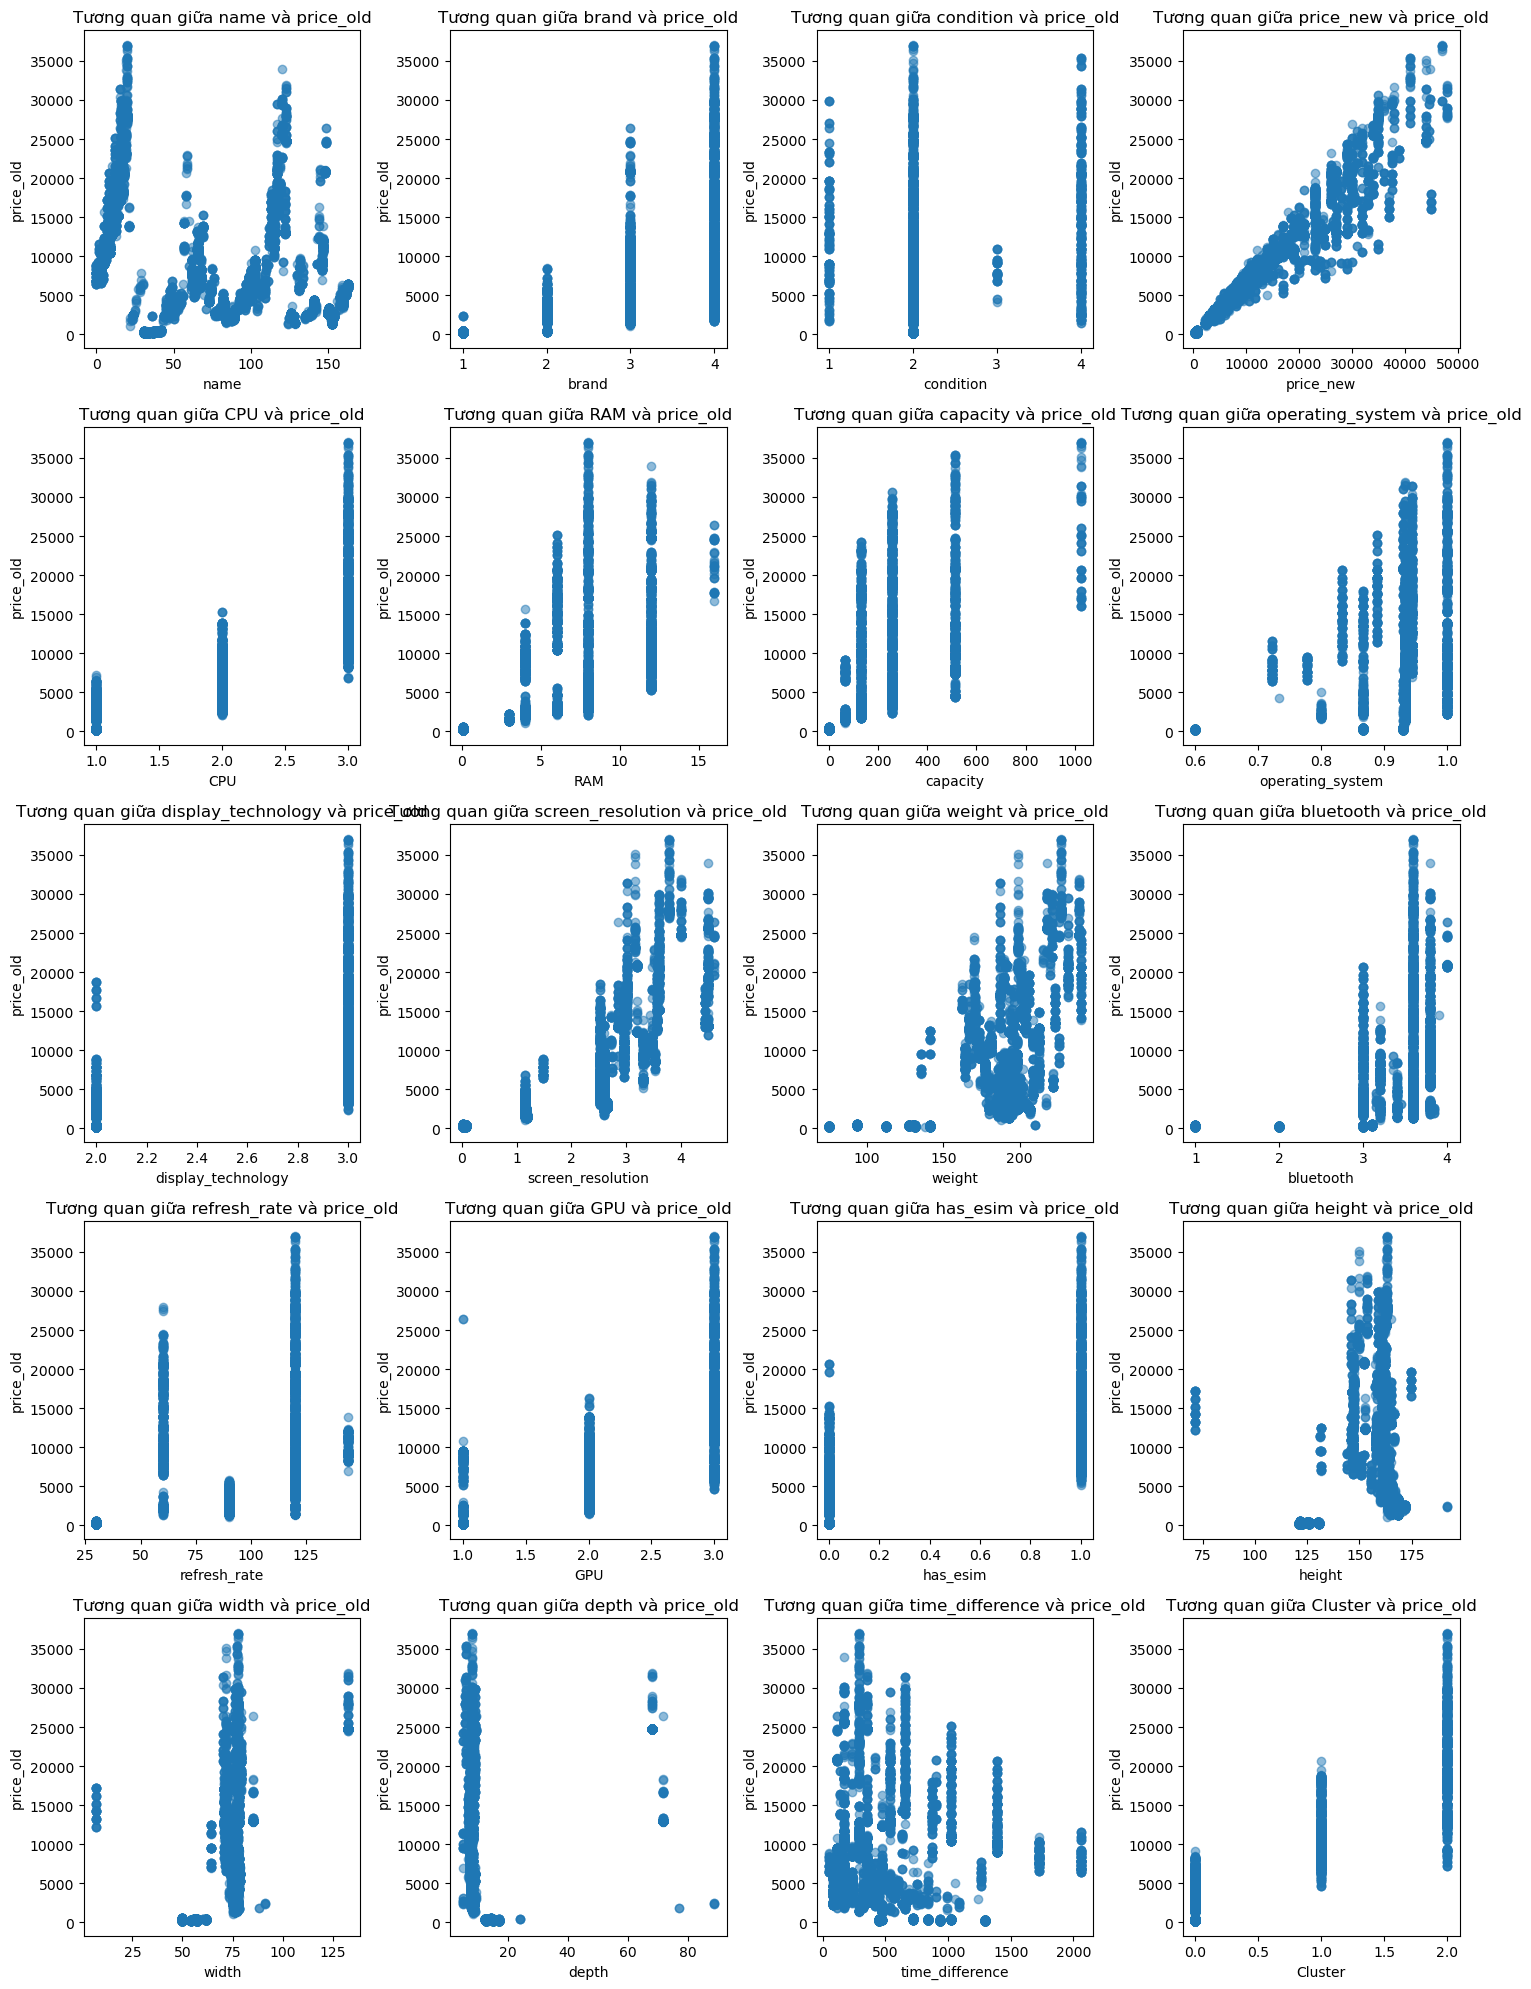

In [36]:
import matplotlib.pyplot as plt

# Lấy danh sách các cột số (ngoại trừ price_old)
numerical_cols = data_clustered.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("price_old")  # Loại bỏ target khỏi danh sách

# Vẽ tất cả các biểu đồ scatter
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, len(numerical_cols)))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].scatter(data_clustered[col], data["price_old"], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("price_old")
    axes[i].set_title(f"Tương quan giữa {col} và price_old")

plt.tight_layout()
plt.show()

In [37]:
data_clustered.duplicated().sum()

8954

In [38]:
data_clustered = data_clustered.drop_duplicates()

In [39]:
data_clustered.shape

(1974, 21)

# Chia tập dữ liệu

In [40]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và tập dev + test theo tỷ lệ 60:40
X_train, X_temp, y_train, y_temp = train_test_split(data_clustered.drop(columns=['price_old']), data_clustered["price_old"], test_size=0.4, random_state=42)

# Chia tiếp tập dev + test thành tập dev (20%) và tập test (20%)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Lưu các dữ liệu sau chia tập

In [41]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv("train.csv")

In [42]:
dev_data = pd.concat([X_dev, y_dev], axis=1)
dev_data.to_csv("dev.csv")

In [43]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv("test.csv")

# Huấn luyện mô hình

In [44]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## XGBRegressor

In [45]:
from xgboost import XGBRegressor

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

print("Các siêu tham số tối ưu: ", xgb.best_params_)
print("MSE tốt nhất:", -xgb.best_score_)
print("RMSE tốt nhất:", np.sqrt(-xgb.best_score_))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Các siêu tham số tối ưu:  {'colsample_bytree': 0.8865639399325217, 'learning_rate': 0.20587335501247445, 'max_depth': 3, 'n_estimators': 485, 'subsample': 0.8308464586228064}
MSE tốt nhất: 819428.3143099151
RMSE tốt nhất: 905.2227981607152


In [46]:
xgb_regressor = xgb.best_estimator_

# Huấn luyện mô hình trên tập train
xgb_regressor.fit(X_train, y_train)

# Dự đoán trên tập dev
y_pred_xgb = xgb_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_xgb)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_xgb)
r2 = r2_score(y_dev, y_pred_xgb)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

MSE trên tập dev: 1081753.9357265632
RMSE trên tập dev: 1040.0740049278047
MAPE trên tập dev: 0.07481164770493624
R² trên tập dev: 0.9820


## LGBMRegressor

In [47]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Tìm số lượng cây tối ưu cho mô hình bởi Early Stopping
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=5000,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=20,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(
        stopping_rounds=50,
        verbose=False
    )],
)

# Số lượng cây tối ưu được chọn bởi Early Stopping
n = lgbm.best_iteration_
print(f"\nSố lượng cây tối ưu (n_estimators) được chọn bởi Early Stopping: {lgbm.best_iteration_}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 1184, number of used features: 20
[LightGBM] [Info] Start training from score 9496.241554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [48]:
# Định nghĩa không gian tham số (param_grid)
param_grid = {
    'n_estimators': [n],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
}

lgbm = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# Lấy kết quả tốt nhất
print("Tham số tốt nhất:", lgbm.best_params_)
print("MSE tốt nhất:", -lgbm.best_score_)
print("RMSE tốt nhất:", np.sqrt(-lgbm.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 1184, number of used features: 20
[LightGBM] [Info] Start training from score 9496.241554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [49]:
# Khởi tạo mô hình với các tham số được tinh chỉnh
lgbm_regressor = lgbm.best_estimator_

# Huấn luyện
lgbm_regressor.fit(X_train, y_train)

# Dự đoán
y_pred_lgbm = lgbm_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_lgbm)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_lgbm)
r2 = r2_score(y_dev, y_pred_lgbm)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 1184, number of used features: 20
[LightGBM] [Info] Start training from score 9496.241554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

## RandomForestRegressor

In [50]:
from sklearn.ensemble import RandomForestRegressor

# Thiết lập grid search với các giá trị siêu tham số cần thử nghiệm
param_grid = {
    "n_estimators": [100, 200, 300],  # Số lượng cây trong rừng
    "max_depth": [None, 10, 20],      # Độ sâu tối đa của cây
    "min_samples_split": [2, 5, 10],  # Số mẫu tối thiểu để chia nút
    "min_samples_leaf": [1, 2, 4],    # Số mẫu tối thiểu ở nút lá
    "max_features": ["sqrt", "log2"]  # Số lượng đặc trưng được chọn ngẫu nhiên
}

# Grid Search với cross-validation 5-fold
rf= GridSearchCV(RandomForestRegressor(random_state=42),
                param_grid = param_grid,
                cv=5,
                scoring="neg_root_mean_squared_error",
                n_jobs=-1,
                verbose=2)

# Huấn luyện
rf.fit(X_train, y_train)

# Kết quả tốt nhất
print("Tham số tốt nhất:", rf.best_params_)
print("MSE tốt nhất:", -rf.best_score_)
print("RMSE tốt nhất:", np.sqrt(-rf.best_score_))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Tham số tốt nhất: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
MSE tốt nhất: 964.6042529063782
RMSE tốt nhất: 31.05807870597243


In [51]:
rf_regressor = rf.best_estimator_

# Dự đoán
y_pred_rf = rf_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_rf)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_rf)
r2 = r2_score(y_dev, y_pred_rf)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

MSE trên tập dev: 1166064.5199888519
RMSE trên tập dev: 1079.8446740105041
MAPE trên tập dev: 0.07624137067410997
R² trên tập dev: 0.9806


## CatBoostRegressor

In [52]:
from catboost import CatBoostRegressor

# Định nghĩa không gian tham số
param_dist = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(loc=0.01, scale=0.15),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(loc=1, scale=5),
}

# Khởi tạo mô hình CatBoostRegressor
cat_model_base = CatBoostRegressor(
    random_state=42,
    loss_function='RMSE',
    eval_metric='R2',
    early_stopping_rounds=50,
    verbose=0,
)

# Khởi tạo RandomizedSearchCV
random_search_catboost = RandomizedSearchCV(estimator=cat_model_base,
                                            param_distributions=param_dist,
                                            n_iter=30,
                                            cv=5,
                                            scoring='r2',
                                            verbose=1,
                                            random_state=42,
                                            n_jobs=-1)

# Huấn luyện mô hình CatBoost với RandomizedSearchCV
random_search_catboost.fit(X_train, y_train,
                           eval_set=(X_dev, y_dev),
                           early_stopping_rounds=50,
                           verbose=100
                           )

# Kết quả tốt nhất
print("Tham số tốt nhất:", random_search_catboost.best_params_)
print("MSE tốt nhất:", random_search_catboost.best_score_)
print("RMSE tốt nhất:", np.sqrt(random_search_catboost.best_score_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Anaconda3\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

0:	learn: 0.1732915	test: 0.1706954	best: 0.1706954 (0)	total: 155ms	remaining: 1m 7s
100:	learn: 0.9905219	test: 0.9784355	best: 0.9784355 (100)	total: 242ms	remaining: 808ms
200:	learn: 0.9925456	test: 0.9803785	best: 0.9803861 (199)	total: 329ms	remaining: 389ms
300:	learn: 0.9931826	test: 0.9809682	best: 0.9809682 (300)	total: 417ms	remaining: 191ms
400:	learn: 0.9934440	test: 0.9811427	best: 0.9811504 (394)	total: 527ms	remaining: 49.9ms
438:	learn: 0.9935063	test: 0.9811689	best: 0.9811715 (434)	total: 570ms	remaining: 0us

bestTest = 0.981171472
bestIteration = 434

Shrink model to first 435 iterations.
Tham số tốt nhất: {'depth': 5, 'iterations': 439, 'l2_leaf_reg': 2.2051273301300585, 'learning_rate': 0.11248952782381873}
MSE tốt nhất: 0.9866694868278687
RMSE tốt nhất: 0.9933123812919422


In [53]:
# Lấy mô hình CatBoost tốt nhất đã được huấn luyện
cb_regressor = random_search_catboost.best_estimator_

# Dự đoán trên tập dev
y_pred_cb = cb_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_cb)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_cb)
r2 = r2_score(y_dev, y_pred_cb)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

MSE trên tập dev: 1131801.2479571318
RMSE trên tập dev: 1063.8614796847999
MAPE trên tập dev: 0.07333278316727423
R² trên tập dev: 0.9812


# Kiểm định

## XGBRegressor

In [54]:
# Dự đoán
y_pred_xgb = xgb_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_xgb)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

MSE trên tập test: 970750.3740164312
RMSE trên tập test: 985.266651225155
MAPE trên tập test: 0.07488222280958692
R² trên tập test: 0.9815


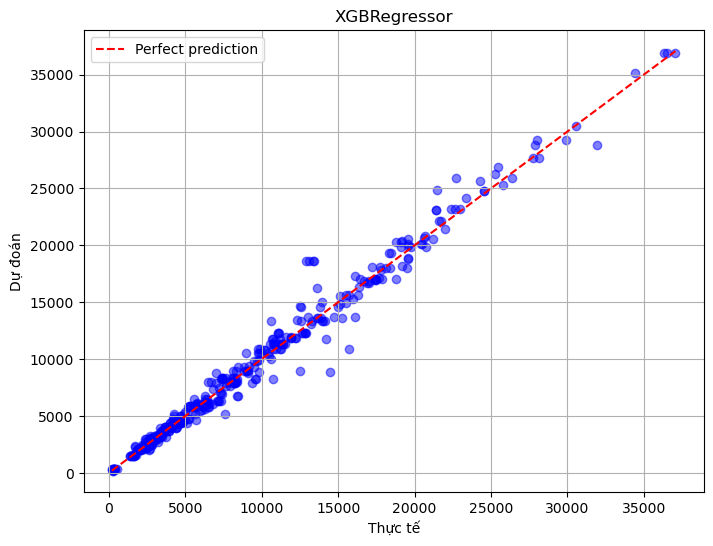

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("XGBRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## LGBM Regressor

In [56]:
# Dự đoán
y_pred_lgbm = lgbm_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_lgbm)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_lgbm)
r2 = r2_score(y_test, y_pred_lgbm)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

MSE trên tập test: 943794.9338356678
RMSE trên tập test: 971.4910878827802
MAPE trên tập test: 0.07266771180238084
R² trên tập test: 0.9820


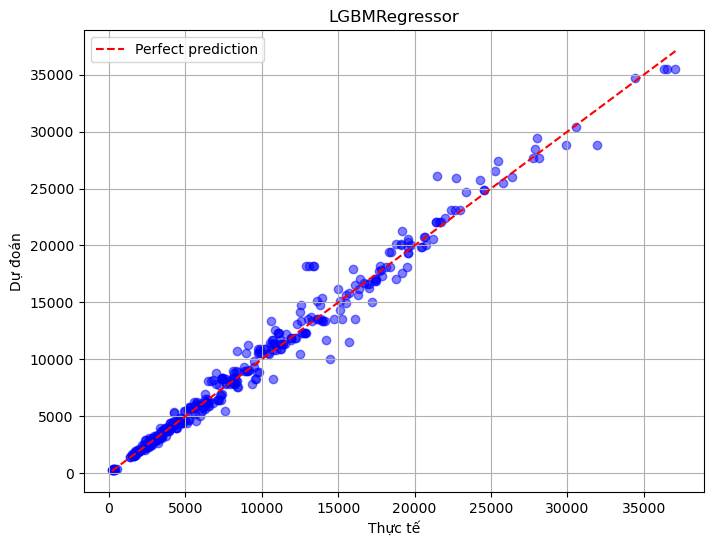

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("LGBMRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## RandomForestRegressor

In [58]:
# Dự đoán
y_pred_rf = rf_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_rf)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

MSE trên tập test: 985663.7497817753
RMSE trên tập test: 992.8059980589236
MAPE trên tập test: 0.0759956609135591
R² trên tập test: 0.9812


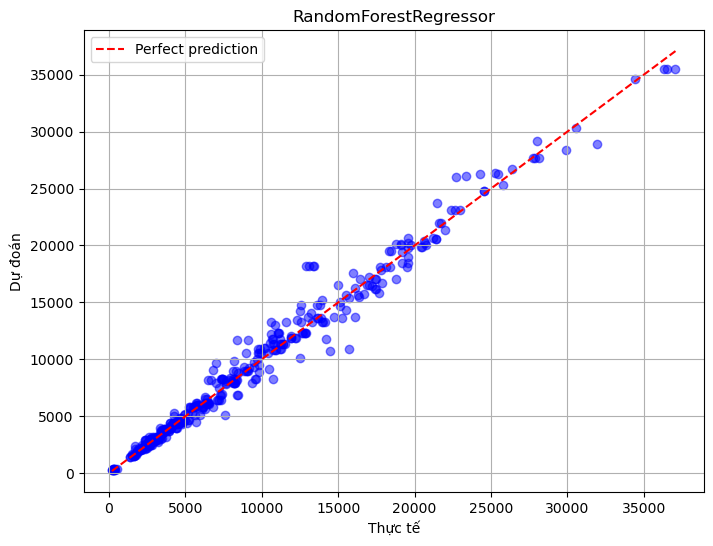

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("RandomForestRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## CatBoostRegressor

In [60]:
# Dự đoán
y_pred_cb = cb_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_cb)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_cb)
r2 = r2_score(y_test, y_pred_cb)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

MSE trên tập test: 894794.4892826367
RMSE trên tập test: 945.9357743962519
MAPE trên tập test: 0.07105456791047333
R² trên tập test: 0.9830


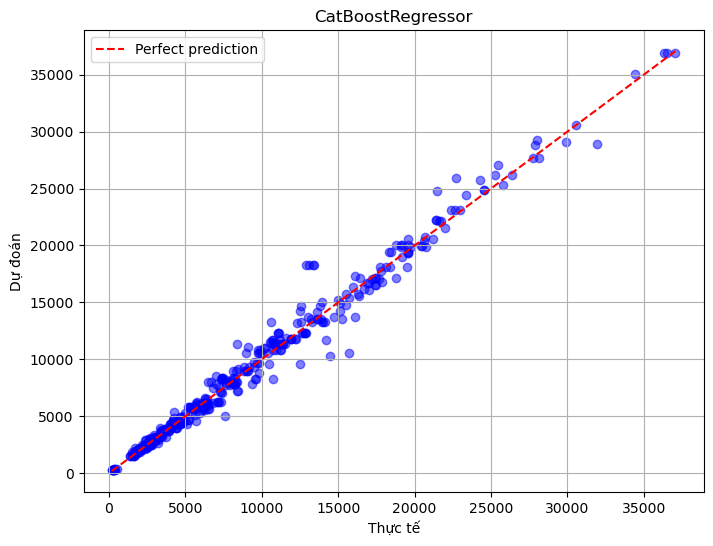

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_cb, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("CatBoostRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

# Lưu mô hình

In [62]:
joblib.dump(xgb_regressor, 'xgb_model.pkl')
joblib.dump(lgbm_regressor, 'lgbm_model.pkl')
joblib.dump(rf_regressor, 'rf_model.pkl')
joblib.dump(cb_regressor, 'cb_model.pkl')

['cb_model.pkl']

# Lưu pipeline

In [64]:
import pandas as pd
from datetime import datetime
import calendar
import numpy as np
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

X_original = pd.read_csv(r'..\preprocessing\tidy_data.csv', encoding='utf-8-sig').drop(columns=['price_old'])

class Dropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore').copy()

class DateTimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['time'] = pd.to_datetime(X_copy['time'], errors='coerce')
        X_copy['time_difference'] = (datetime.now() - X_copy['time']).dt.days

        current_date_for_warranty = datetime.now()
        warranty_processed_list = []

        for item in X_copy['warranty']:
            if pd.isna(item):
                warranty_processed_list.append(np.nan)
                continue
            item_str = str(item).strip()
            if "tháng" in item_str:
                num_months_str = item_str.replace("tháng", "").strip()
                try:
                    num_months = int(num_months_str)
                except ValueError:
                    warranty_processed_list.append(np.nan)
                    continue
                year = current_date_for_warranty.year
                month = current_date_for_warranty.month + num_months
                day = current_date_for_warranty.day
                while month > 12:
                    month -= 12
                    year += 1
                try:
                    new_date = datetime(year, month, day)
                except ValueError:
                    last_day_of_month = calendar.monthrange(year, month)[1]
                    new_date = datetime(year, month, last_day_of_month)
                warranty_processed_list.append(new_date)
            else:
                try:
                    warranty_processed_list.append(datetime.strptime(item_str, "%d/%m/%Y"))
                except ValueError:
                    warranty_processed_list.append(np.nan)

        X_copy['warranty_processed'] = warranty_processed_list
        current_date_series = pd.Series([current_date_for_warranty] * len(X_copy), index=X_copy.index)
        time_remaining = X_copy['warranty_processed'] - current_date_series
        X_copy['day_remaining_warranty'] = time_remaining.dt.days + 1

        return X_copy.copy()

class OperatingSystemTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_score = None

    def get_update_score(self, os_name):
        if pd.isnull(os_name):
            return np.nan
        if os_name.startswith("iOS"):
            match = re.search(r"iOS\s*(\d+)", os_name)
            if match:
                version = int(match.group(1))
                return version / 18
        elif os_name.startswith("Android"):
            match = re.search(r"Android\s*(\d+)", os_name)
            if match:
                version = int(match.group(1))
                return version / 15
        return np.nan

    def fit(self, X, y=None):
        scores = X['operating_system'].apply(self.get_update_score)
        self.mean_score = scores.mean()
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['operating_system'] = X_copy['operating_system'].apply(self.get_update_score)
        X_copy['operating_system'].fillna(self.mean_score, inplace=True)
        return X_copy

class CPUTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        high_pattern = re.compile(
            r'(?i)(?:a18|a17|a16|a15(?:\sbionic)?|snapdragon\s8(?:\sgen\s3|\sgen\s2|\+?\sgen\s1)|8\selite|'
            r'exynos\s2400(?:e)?|exynos\s2200|dimensity\s(?:9300\+|9400|9200|8300))'
        )
        mid_pattern = re.compile(
            r'(?i)(?:a14(?:\sbionic)?|a13(?:\sbionic)?|snapdragon\s(?:7(?:\sgen\s[13]|s\sgen\s2)|'
            r'6\sgen\s[134]|6s\s(?:gen\s1|4g\sgen\s1))|exynos\s(?:2100|15[80]|14[80]|13[80]|1280)|'
            r'dimensity\s(?:1080|7050|7025|7300|6300|6100\+|6020|700|8350|d6300))'
        )
        low_pattern = re.compile(
            r'(?i)(?:snapdragon\s(?:6[895]|680(?:\s4g)?|sm6225)|helio\s(?:g(?:99|96|92|91|88|85|81|36|35)|'
            r'p35|g100)|mt6762|unisoc\s(?:t(?:7250|7225|615|612|606|107)|ums9117)|tiger\s?t693)'
        )

        def classify_cpu(cpu):
            if pd.isnull(cpu):
                return 1
            cpu = cpu.strip()
            if high_pattern.search(cpu):
                return 3
            elif mid_pattern.search(cpu):
                return 2
            elif low_pattern.search(cpu):
                return 1
            else:
                return 1

        X_copy['CPU'] = X_copy['CPU'].apply(classify_cpu).astype(int)
        return X_copy

class ConditionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        condition_mapping = {'Cũ trầy xước cấn': 1, 'Cũ trầy xước': 2, 'Cũ': 3, 'Cũ đẹp': 4}
        X_copy['condition'] = X_copy['condition'].map(condition_mapping).fillna(np.nan)
        return X_copy.copy()

class BrandTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        brand_mapping = {
            'apple': 4, 'samsung': 4,
            'honor': 3, 'oppo': 3, 'xiaomi': 3, 'vivo': 3,
            'realme': 2, 'tecno': 2, 'nokia': 2, 'tcl': 2,
            'mobell': 1, 'viettel': 1, 'masstel': 1
        }
        X_copy['brand'] = X_copy['brand'].str.lower().map(brand_mapping).fillna(np.nan)
        return X_copy.copy()

class NameEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        mapping = {label: idx for idx, label in enumerate(self.encoder.classes_)}
        X_copy['name'] = X_copy['name'].map(mapping).fillna(-1).astype(int)
        return X_copy.copy()

class GPUTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        high_cond = X_copy['GPU'].str.lower().str.contains(
            'adreno-7|adreno-8|mali-g7|mali-g76|mali-g77|mali-g78|apple-gpu 6|apple-gpu 5|immortalis|xclipse|powervr-series7xt', na=False)
        low_cond = X_copy['GPU'].str.lower().str.contains(
            'adreno-6|adreno-5|adreno-4|mali-g6|mali-g57|mali-g68|mali-g52|powervr-ge8320|xclipse-920|apple-gpu 4|adreno-619|adreno-644|adreno-670', na=False)
        no_gpu_cond = X_copy['GPU'].isna() | (X_copy['GPU'].str.lower() == 'unknown')
        conditions = [no_gpu_cond, high_cond, low_cond]
        choices = ['1', '3', '2']
        X_copy['GPU'] = np.select(conditions, choices, default='1')
        X_copy['GPU'] = pd.to_numeric(X_copy['GPU'], errors='coerce')
        return X_copy.copy()

class BluetoothTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        version_score_map = {
            '2.1': 1.0, '4.2': 2.0, '5.0': 3.0, '5.1': 3.2, '5.2': 3.4, '5.3': 3.6, '5.4': 3.8, '6.0': 4.0
        }
        profile_points = {
            'apt-X Adaptive': 0.2, 'apt-X HD': 0.15, 'LHDC': 0.15, 'apt-X': 0.1, 'A2DP': 0.1, 'LE': 0.1, 'BLE': 0.05
        }
        def encode_bluetooth_weighted(bluetooth_str):
            if pd.isna(bluetooth_str):
                return np.nan
            version_match = re.findall(r'v(\d\.\d)', bluetooth_str)
            version = version_score_map.get(version_match[0], 0) if version_match else 0
            profile_score = sum(pt for profile, pt in profile_points.items() if profile in bluetooth_str)
            return round(version + profile_score, 2)
        X_copy['bluetooth'] = X_copy['bluetooth'].apply(encode_bluetooth_weighted)
        return X_copy.copy()

class PriceNewTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        if 'price_new' in X_copy.columns:
            X_copy['price_new'] = X_copy['price_new'].fillna(0) / 1000
        return X_copy.copy()

class ScreenResolutionTrasformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        if 'screen_resolution' in X_copy.columns:
            X_copy['screen_resolution'] = pd.to_numeric(X_copy['screen_resolution'], errors='coerce')
            X_copy['screen_resolution'] = X_copy['screen_resolution'].fillna(0) / 1000000
        return X_copy.copy()

class DisplayTechnologyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        LCD = X_copy['display_technology'].str.lower().str.contains(
            'lcd|tn|liquid', na=False)

        OLED = X_copy['display_technology'].str.lower().str.contains(
            'oled|amoled|super retina xdr', na=False)

        no_display_technology = X_copy['display_technology'].isna() | (X_copy['display_technology'].str.lower() == 'unknown')

        conditions = [no_display_technology, LCD, OLED]
        choices = ['1', '2', '3']

        X_copy['display_technology'] = np.select(conditions, choices, default='1')
        X_copy['display_technology'] = pd.to_numeric(X_copy['display_technology'], errors='coerce')

        return X_copy.copy()

class KMeansClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, kmeans_model, feature_names_at_imputer_stage=None):
        self.kmeans_model = kmeans_model
        self.feature_names_at_imputer_stage = feature_names_at_imputer_stage

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.feature_names_at_imputer_stage is None:
            raise ValueError("KMeansClusterTransformer requires 'feature_names_at_imputer_stage' to be set in its constructor.")

        if not isinstance(X, pd.DataFrame):
            X_df_reconstructed = pd.DataFrame(X, columns=self.feature_names_at_imputer_stage)
        else:
            X_df_reconstructed = X.copy()

        kmeans_expected_features = self.kmeans_model.feature_names_in_ if hasattr(self.kmeans_model, 'feature_names_in_') else self.feature_names_at_imputer_stage
        for col in kmeans_expected_features:
            if col not in X_df_reconstructed.columns:
                X_df_reconstructed[col] = 0

        X_cluster = X_df_reconstructed[kmeans_expected_features].copy()

        X_df_reconstructed['Cluster'] = self.kmeans_model.predict(X_cluster)
        return X_df_reconstructed.copy()


try:
    name_encoder = joblib.load('name_label_encoder.pkl')
    kmeans_model = joblib.load('kmeans_model.pkl')
    print("Đã tải thành công các encoder và KMeans model từ file .pkl.")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy một hoặc nhiều file encoder/KMeans .pkl.")
    print("Vui lòng đảm bảo các file này đã được tạo và lưu trong thư mục 'modeling/' trước khi chạy phần này.")
    raise

final_dropper_cols_for_pipeline = [
    'image', 'screen_size', 'battery',
    'time', 'warranty', 'warranty_processed',
    'color', 'has_nano_sim', 'price_old', 'day_remaining_warranty'
]

temp_pipeline_for_feature_names_pre_imputer_kmeans = Pipeline([
    ('initial_dropper', Dropper(columns=['image'])),
    ('datetime_features', DateTimeFeaturesTransformer()),
    ('screen_resolution_transformer', ScreenResolutionTrasformer()),
    ('condition_transformer', ConditionTransformer()),
    ('brand_transformer', BrandTransformer()),
    ('name_encoder', NameEncoder(encoder=name_encoder)),
    ('gpu_transformer', GPUTransformer()),
    ('bluetooth_transformer', BluetoothTransformer()),
    ('price_new_transformer', PriceNewTransformer()),
    ('cpu_transformer', CPUTransformer()),
    ('operating_system_transformer', OperatingSystemTransformer()),
    ('display_technology_transformer', DisplayTechnologyTransformer()),
    ('final_dropper_for_cols', Dropper(columns=[col for col in final_dropper_cols_for_pipeline if col != 'image']))
])

temp_X_transformed_pre_imputer_kmeans = temp_pipeline_for_feature_names_pre_imputer_kmeans.fit_transform(X_original.copy())
feature_names_at_imputer_stage = temp_X_transformed_pre_imputer_kmeans.columns.tolist()
print(f"Các đặc trưng trước imputer/KMeans: {feature_names_at_imputer_stage}")

prediction_pipeline = Pipeline([
    ('initial_dropper', Dropper(columns=['image'])),
    ('datetime_features', DateTimeFeaturesTransformer()),
    ('screen_resolution_transformer', ScreenResolutionTrasformer()),
    ('condition_transformer', ConditionTransformer()),
    ('brand_transformer', BrandTransformer()),
    ('name_encoder', NameEncoder(encoder=name_encoder)),
    ('gpu_transformer', GPUTransformer()),
    ('bluetooth_transformer', BluetoothTransformer()),
    ('price_new_transformer', PriceNewTransformer()),
    ('cpu_transformer', CPUTransformer()),
    ('operating_system_transformer', OperatingSystemTransformer()),
    ('display_technology_transformer', DisplayTechnologyTransformer()),
    ('final_dropper', Dropper(columns=[col for col in final_dropper_cols_for_pipeline if col != 'image'])),
    ('imputer', SimpleImputer(strategy='mean')),
    ('kmeans_cluster', KMeansClusterTransformer(kmeans_model=kmeans_model, feature_names_at_imputer_stage=feature_names_at_imputer_stage))
])

print("Đang fit pipeline dự đoán...")
fitted_prediction_pipeline = prediction_pipeline.fit(X_original.copy())
print("Pipeline dự đoán đã được fit thành công.")

joblib.dump(fitted_prediction_pipeline, 'prediction_pipeline.pkl')
print("prediction_pipeline.pkl đã được lưu thành công.")

Đã tải thành công các encoder và KMeans model từ file .pkl.


C:\Users\Phuong Anh\AppData\Local\Temp\ipykernel_24440\1989006932.py:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy['operating_system'].fillna(self.mean_score, inplace=True)


Các đặc trưng trước imputer/KMeans: ['name', 'brand', 'condition', 'price_new', 'CPU', 'RAM', 'capacity', 'operating_system', 'display_technology', 'screen_resolution', 'weight', 'bluetooth', 'refresh_rate', 'GPU', 'has_esim', 'height', 'width', 'depth', 'time_difference']
Đang fit pipeline dự đoán...
Pipeline dự đoán đã được fit thành công.
prediction_pipeline.pkl đã được lưu thành công.


C:\Users\Phuong Anh\AppData\Local\Temp\ipykernel_24440\1989006932.py:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy['operating_system'].fillna(self.mean_score, inplace=True)
